
# Ising fitter for capped repeat proteins with mutations.

Authors:  Doug Barrick, Jacob D. Marold, Kathryn Geiger-Schuller, Tural Aksel, Ekaterina Poliakova-Georgantas, Sean Klein, Kevin Sforza, Mark Peterson

Most recent revision: 05/21/2020

This notebook reads data from Aviv data files, converts the data to normalized unfolding transitions, generates partition functions and expressions for fraction folded, and uses these expressions to fit the normalized transitions.  Data and fits are plotted in various ways, and bootstrap analysis is performed.  Correlation plots are generated for pairs of bootstrap parameter values.

In this notebook, constructs of NRC type are fitted along with constructs of NXC type, where X repeats are R repeats with point substitutions.  The data analyzed are consensus ankyrin repeets collected by Tural Aksel, along with T4V-substituted consensus ankyrin repeats collected by Kevin Sforza.  The data conversion script takes two csv files, one containing the NRC data and the other containing the T4V data (I don't have the original Aviv .dat files for T4V) and are separated and converted into .npy files for fitting.  This script also generates the constructs.txt and melts.txt lists.

Here I am fitting two separate m values, one for R and one for X repeats.  This fits better than one m-value.

## Imports, path, and project name

Path and project name should be set by the user.  Note that because of the kernel restart below, these must be specified in subsequent scripts, along with any other imports that are needed.

In [1]:
import numpy as np  
import glob     
import csv
import pandas as pd
import os
import json
import time
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import lmfit

path = os.getcwd()

proj_name = 'T4V_NRC_2mi'

## Data conversion from *two* csv files.

In this script, data are read from two csv files using pandas dataframes.  There is a csv file for the T4V data, and a second for the NRC data.  Imported to dataframes and combined into a final dataframe.
Outputs are

1.  A numpy data file for each melt, contining [denaturant], normalized signal, construct ID, and melt ID.

2.  A list of constructs.

3.  A list of melts.

4.  A combined csv file with all melts (T4V and NRC).

For the lists of constructs and melts, there are loops that attempt to put the constructs and melts in order so that they appear in a logical progression from short to long and depending on repeat type.

In [2]:
den_nsig_const_melt = []
constructs = []         # List of constructs used to build partition functions in next script
melts = []              # List of melts to be used in fitting script

t4v_filepath = os.path.join(path, 'T4Vdata_not_normalized.csv')
nrc_filepath = os.path.join(path, 'NRC_data_dnmn.csv')

T4V_input_df = pd.read_csv(t4v_filepath,names=['denat','signal','construct_melt','dataset'])
NRC_input_df = pd.read_csv(nrc_filepath,names=['denat','signal','construct_melt','dataset'])
maxT4Vmelt = T4V_input_df['dataset'].max()  # Finds the maximum number of melts in the first df
NRC_input_df['dataset'] = NRC_input_df['dataset'] + maxT4Vmelt # Adds the max number to the melt numbers in second df
combined_input_df = pd.concat([T4V_input_df, NRC_input_df],names=['denat','signal','construct_melt','dataset'])
combined_input_df.to_csv('{}T4V_NRC_dnmn.csv'.format(path), index=False, header=False)

num_melts=combined_input_df['dataset'].max()
for melt in np.arange(num_melts)+1:
    temp_df = combined_input_df.loc[combined_input_df.dataset == melt] # Pulls out just one melt
        
    # Normalizing the signal
    min = temp_df['signal'].min()
    max = temp_df['signal'].max()
    series=(temp_df['signal'] - min)/(max - min)
    temp_df['signal'] = series  # Overwrites un-normalized signal
    temp_df.rename(columns={'signal': 'nsig'}, inplace=True)
    temp_list = temp_df.values.tolist()
    temp_nparray = np.array(temp_list)
    construct_melt = temp_df.iloc[0, 2]
    np.save(path + construct_melt, temp_nparray) # Writes an npy file to disk for each melt.
    melts.append(construct_melt)

''' 
This loop puts melts in order of type (NRxC, NRx, RxC) and length.  This is useful for the
plotting script below, putting the by_melt legends in a sensible order
'''
NRClist = []
NRlist = []
RClist = []
melts.sort()
i = 0
for melt in melts:
    if melt[0] == 'N':
        if melt[-3] == 'C':
            NRClist.append(melt)
        else:
            NRlist.append(melt)
    else:
        RClist.append(melt)

NRClist.sort(key=len)
NRlist.sort(key=len)
RClist.sort(key=len)
melts = NRClist + NRlist + RClist
    
# Generate a list of just the constructs.  The loop removes duplicates.
for melt in melts: 
    if melt[:-2] not in constructs: 
        constructs.append(melt[:-2]) 
         
with open("{0}{1}_constructs.txt".format(path, proj_name), 'w') as r:
    json.dump(constructs, r)

with open("{0}{1}_melts.txt".format(path, proj_name), 'w') as s:
    json.dump(melts, s)  


<ipython-input-2-d51bf6fa0cbb>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['signal'] = series  # Overwrites un-normalized signal
/home/xtremejake/anaconda3/envs/ising_py3/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


## Generate a partition function and fraction folded expressions for fitting.

Inputs the constructs.txt, melts.txt, and processed .npy data files from the data processing script above.

Generates a dictionary of partition functions using the capped homopolymer 1D-Ising model, and converts these to dictionaries of fraction-folded expressions (**fraction_folded_dict**) for fitting by partial differentiation.  Manipulations are done using the sympy module which allows symbolic math operations.  This is important for partial differentiation, but also for "simplification" of the fraction folded exprssions.  This simplification factors common terms, significantly decreasing the time it takes to fit and bootstrap below.  The fraction-folded dictionary is exported in json format.

Because the numpy exponential function (np.exp) gets reassigned in this script, and I cannot figure out how to undo this, the kernel must be restarted at the bottom of the script (exit()).  The user will be prompted to accept.

Though the path, project name, and most (but not all imports) are redundant with the command above, the kernel restart at the end of this script can create problems, if the script is run more than once.  For this reason I am keeping them associated with this script (and with subsequent scripts--fitting, plotting, etc).

Note that on 2020_05_05, I am changing the equation that gives the denaturant dependence of DGi to DGi + mi denat in the three equations for N, R, and C.  This corresponds to a positive m-value (free energies become more positive with denaturant).  Also change initial guess in the fitting cell.

In [3]:
start = time.time()

print('Generating partition functions and fraction folded expressions.  This may take a minute...')

# Parameters for partition function calculation.  Note these are sympy symbols.
RT = sp.Symbol('RT')
dGN = sp.Symbol('dGN')
dGR = sp.Symbol('dGR')
dGX = sp.Symbol('dGX')
dGC = sp.Symbol('dGC')
dGRR = sp.Symbol('dGRR')
dGXX = sp.Symbol('dGXX')
dGXR = sp.Symbol('dGXR')
dGRX = sp.Symbol('dGRX')
mR = sp.Symbol('mR')
mX = sp.Symbol('mX')
denat = sp.Symbol('denat')
KN = sp.Symbol('KN')
KR = sp.Symbol('KR')
KX = sp.Symbol('KX')
KC = sp.Symbol('KC')
TRR = sp.Symbol('TRR')
TXX = sp.Symbol('TXX')
TXR = sp.Symbol('TXR')
TRX = sp.Symbol('TRX')

exp = sp.Function('np.exp')

with open('{0}{1}_constructs.txt'.format(path, proj_name)) as cons:
    constructs = json.load(cons)

#define weight matricies and end vectors to be used to calculate partition functions
begin = sp.Matrix([[0,1]])
woN = sp.Matrix([[KN,1],[KN,1]]) # Leave off coupling term.  No zeroth repeat
woR = sp.Matrix([[KR,1],[KR,1]]) # Leave off coupling term.  No zeroth repeat
woX = sp.Matrix([[KX,1],[KX,1]]) # Leave off coupling term.  No zeroth repeat

wnR = sp.Matrix([[KR*TRR,1],[KR,1]]) # Treat coupling same as an rR interface, as usual
wrR = sp.Matrix([[KR*TRR,1],[KR,1]]) # Same as wnR above
wxR = sp.Matrix([[KR*TXR,1],[KR,1]])

wnX = sp.Matrix([[KX*TRX,1],[KX,1]]) # Different coupling than 
wrX = sp.Matrix([[KX*TRX,1],[KX,1]]) # Different coupling than wnX above
wxX = sp.Matrix([[KX*TXX,1],[KX,1]])

wrC = sp.Matrix([[KC*TRR,1],[KC,1]]) # Treat copuling same as an rR interface, as usual
wxC = sp.Matrix([[KC*TXR,1],[KC,1]])

end = sp.Matrix([[1],[1]])

# Build a dictionary of these matrices
w_dict = {'oN': woN, 
         'oR': woR,
         'oX': woX,
         'nR': wnR,
         'rR': wrR,
         'xR': wxR,
         'nX': wnX,
         'rX': wrX,
         'xX': wxX,
         'rC': wrC,
         'xC': wxC}

# Build dictionaries of partition functions, partial derivs with respect
# to K, and fraction folded.

q_dict = {}
dqdKN_dict = {}
dqdKR_dict = {}
dqdKX_dict = {}
dqdKC_dict = {}
frac_folded_dict = {}

# Number of repeats of each type.  Seems like they should be floats, but
# I get an error in the matrix multiplication (q_dict) if they are declared to be.


for construct in constructs:

    # Make partition function dictionary and expressions for fraction folded. 
    # Note, only one pf is generated per construct, even when there are multiple melts.
    
    repeat_list = construct.split('_')
    repeat_list.insert(0, 'o')
    
    pairs_list = []
    i = 1
    while i < len(repeat_list):
        pair = repeat_list[i-1].lower() + repeat_list[i] # Need to convert prev rept to lower case
        pairs_list.append(pair)
        i = i + 1
    
    q_dict[construct + '_q'] = begin
    
    for pair in pairs_list:
        q_dict[construct + '_q'] = q_dict[construct + '_q'] * w_dict[pair]
    
    q_dict[construct + '_q']  = q_dict[construct + '_q'] * end
    
    # Next two lines convert from sp.Matrix to np.array to something else.
    # Not sure the logic here, but it works.
    q_dict[construct + '_q'] = np.array(q_dict[construct + '_q']) 
    q_dict[construct + '_q'] = q_dict[construct + '_q'].item(0)
        
    # Partial derivs wrt KN dictionary.
    dqdKN_dict[construct + '_dqdKN'] \
        = sp.diff(q_dict[construct + '_q'], KN)

    # Partial derivs wrt KR dictionary.
    dqdKR_dict[construct + '_dqdKR'] \
        = sp.diff(q_dict[construct + '_q'], KR)
    
    # Partial derivs wrt KX dictionary.
    dqdKX_dict[construct + '_dqdKX'] \
        = sp.diff(q_dict[construct + '_q'], KX)

    # Partial derivs wrt KC dictionary.
    dqdKC_dict[construct + '_dqdKC'] \
        = sp.diff(q_dict[construct + '_q'], KC)
    
    # Fraction folded dictionary.  
    frac_folded_dict[construct + '_frac_folded'] \
        = (KN/(q_dict[construct + '_q']) * dqdKN_dict[construct + '_dqdKN'] \
         + KR/(q_dict[construct + '_q']) * dqdKR_dict[construct + '_dqdKR'] \
         + KX/(q_dict[construct + '_q']) * dqdKX_dict[construct + '_dqdKX'] \
         + KC/(q_dict[construct + '_q']) * dqdKC_dict[construct + '_dqdKC']) \
        / (len(pairs_list))

# The loop below replaces K's and W's the fraction folded terms in the 
# dictionary with DGs, ms, and denaturant concentrations.  The simplify line
# is really important for making compact expressions for fraction folded.
# This simplification greatly speeds up fitting.  The last line
# converts from a sympy object to a string, to allow for json dump.

for construct in frac_folded_dict:
    frac_folded_dict[construct] = frac_folded_dict[construct].subs({
    KN:(exp(-((dGN + (mR*denat))/RT))), 
    KR:(exp(-((dGR + (mR*denat))/RT))), 
    KX:(exp(-((dGX + (mX*denat))/RT))),
    KC:(exp(-((dGC + (mR*denat))/RT))),  
    TRR:(exp(-dGRR/RT)), 
    TXX:(exp(-dGXX/RT)), 
    TXR:(exp(-dGXR/RT)),
    TRX:(exp(-dGRX/RT)) }) 
    frac_folded_dict[construct] = sp.simplify(frac_folded_dict[construct])
    frac_folded_dict[construct] = str(frac_folded_dict[construct])                                

with open('{0}{1}_frac_folded_dict.txt'.format(path, proj_name), 'w') as f:
    json.dump(frac_folded_dict, f)
        

'''
The exit statement below quits the kernel, which is required before the Ising
fitter is run (presumably because np.exp gets reassigned, and I am not sure
how to un-assign it).  The only disadvantage to this approach is that you 
will not be able to inspect the output of the present script (and the fraction
folded dictionary in particular).  If you need to see these results, comment
out the exit command, and uncomment the warning print statement, so you don't
forget to restart the kernel before fitting.
'''
 
stop = time.time()
runtime = stop - start
print('\nThe elapsed time was ' + str(runtime) + ' sec') 

print('\n')
print('''The kernel is about to restart to avoid errors associated with the
reassignment of np.exp above, which inteferes with the Ising fitter.  If you
need to see the variable space that results from running this script, comment
out the exit() command below.''')

Generating partition functions and fraction folded expressions.  This may take a minute...

The elapsed time was 23.359464168548584 sec


The kernel is about to restart to avoid errors associated with the
reassignment of np.exp above, which inteferes with the Ising fitter.  If you
need to see the variable space that results from running this script, comment
out the exit() command below.


## Fitting the data with the Ising model

Processed data files are imported along with the fraction-folded dictionary and construct and melt lists.  The fit is performed with the lmfit module, which has extra functionality over fitting routines in scipy.  

Note that if your initial guesses are poor, the fit may be slowed significantly or the fit may not converge.

Fitted thermodynamic parameters are outputted to the screen and are written to a csv file.  Baseline parameters are also written to a csv file.

In [4]:
print("\nFitting the data...\n")

start = time.time()

plt.close()
plt.clf

RT = 0.001987 * 298.15 #  R in kcal/mol/K, T in Kelvin.

#  Dictionary of frac folded eqns from partition function generator script.
with open('{0}{1}_frac_folded_dict.txt'.format(path, proj_name)) as ffd:
    frac_folded_dict = json.load(ffd)

with open('{0}{1}_constructs.txt'.format(path, proj_name)) as construct:
    constructs = json.load(construct)

with open('{0}{1}_melts.txt'.format(path, proj_name)) as m:
    melts = json.load(m)

num_melts = len(melts)
num_constructs = len(constructs)

melt_data_dict = {}
for melt in melts:
   melt_data_dict[melt] = np.load('{0}{1}.npy'.format(path, melt), allow_pickle=True)

# Compile fraction folded expressions.
comp_frac_folded_dict = {}
for construct in constructs:
    frac_folded_string = frac_folded_dict[construct + '_frac_folded']
    comp_frac_folded = compile(frac_folded_string, '{}_comp_ff'.format(construct), 'eval')
    comp_frac_folded_dict[construct + '_comp_ff'] = comp_frac_folded

# CREATE INITIAL GUESSES
# First, thermodynamic parameters.  These are Global.
init_guesses = lmfit.Parameters()
init_guesses.add('dGN', value = 5)
init_guesses.add('dGR', value = 4)
init_guesses.add('dGX', value = 5)
init_guesses.add('dGC', value = 6)
init_guesses.add('dGRR', value = -11)
init_guesses.add('dGXX', value = -10)
init_guesses.add('dGRX', value = -10)
init_guesses.add('dGXR', value = -10)
init_guesses.add('mR', value = 0.8)
init_guesses.add('mX', value = 0.8)

# Next, baseline parameters.  These are local.
for melt in melts:
    init_guesses.add('af_{}'.format(melt), value=0.02)
    init_guesses.add('bf_{}'.format(melt), value=1)
    init_guesses.add('au_{}'.format(melt), value=0.0)
    init_guesses.add('bu_{}'.format(melt), value=0.0)

# Transfers init_guesses to params for fitting, but init_guesses are maintained.
params = init_guesses

def fitting_function(params, denat, frac_folded, melt):
    af = params['af_{}'.format(melt)].value
    bf = params['bf_{}'.format(melt)].value
    au = params['au_{}'.format(melt)].value
    bu = params['bu_{}'.format(melt)].value
    dGN = params['dGN'].value
    dGR = params['dGR'].value
    dGX = params['dGX'].value
    dGC = params['dGC'].value
    dGRR = params['dGRR'].value
    dGXX = params['dGXX'].value
    dGRX = params['dGRX'].value
    dGXR = params['dGXR'].value
    mR = params['mR'].value
    mX = params['mX'].value
    return ((af * denat) + bf) * frac_folded + (((au * denat) + bu) * (1 - frac_folded))

# Objective function creates an array of residuals to be used by lmfit minimize.
def objective(params):
    resid_dict = {}
    dGN = params['dGN'].value  
    dGR = params['dGR'].value   
    dGC = params['dGC'].value
    dGX = params['dGX'].value
    dGRR = params['dGRR'].value
    dGXX = params['dGXX'].value
    dGRX = params['dGRX'].value
    dGXR = params['dGXR'].value   
    mR = params['mR'].value
    mX = params['mX'].value
    for melt in melts:   
        denat = melt_data_dict[melt][:,0]     # A numpy array of type str
        norm_sig = melt_data_dict[melt][:,1]  # A numpy array of type str
        denat = denat.astype(float) # A numpy array of type float
        norm_sig = norm_sig.astype(float) # A numpy array of type float
        string_to_eval = comp_frac_folded_dict[melt[:-2] + '_comp_ff']
        frac_folded = eval(string_to_eval)
        af = params['af_{}'.format(melt)].value
        bf = params['bf_{}'.format(melt)].value
        au = params['au_{}'.format(melt)].value
        bu = params['bu_{}'.format(melt)].value
        resid = norm_sig - fitting_function(params, denat, frac_folded, melt)
        resid_dict[melt + '_resid'] = resid
    residuals = np.concatenate(list(resid_dict.values()))
    return residuals

# Fit with lmfit
result = lmfit.minimize(objective, init_guesses)
fit_resid = result.residual

# Print out features of the data, the fit, and optimized param values
print("There are a total of {} data sets.".format(num_melts))
print("There are {} observations.".format(result.ndata))
print("There are {} fitted parameters.".format(result.nvarys))
print("There are {} degrees of freedom. \n".format(result.nfree))
print("The sum of squared residuals (SSR) is: {0:7.4f}".format(result.chisqr))
print("The reduced SSR (SSR/DOF): {0:8.6f} \n".format(result.redchi))

dGN = result.params['dGN'].value
dGR = result.params['dGR'].value
dGX = result.params['dGX'].value
dGC = result.params['dGC'].value
dGRR = result.params['dGRR'].value
dGXX = result.params['dGXX'].value
dGRX = result.params['dGRX'].value
dGXR = result.params['dGXR'].value
mR = result.params['mR'].value
mX = result.params['mX'].value

print('Optimized parameter values:')
print('dGN = {0:8.4f}'.format(result.params['dGN'].value))
print('dGR = {0:8.4f}'.format(result.params['dGR'].value))
print('dGX ={0:8.4f}'.format(result.params['dGX'].value))
print('dGC ={0:8.4f}'.format(result.params['dGC'].value))
print('dGRR ={0:8.4f}'.format(result.params['dGRR'].value))
print('dGXX ={0:8.4f}'.format(result.params['dGXX'].value))
print('dGRX ={0:8.4f}'.format(result.params['dGRX'].value))
print('dGXR ={0:8.4f}'.format(result.params['dGXR'].value))
print('mR ={0:8.4f}'.format(result.params['mR'].value))
print('mX ={0:8.4f}'.format(result.params['mX'].value))

print("\nWriting best fit parameter and baseline files")

# Compile a list of optimized Ising params and write to file.
fitted_ising_params = [["dGN", result.params['dGN'].value], 
                        ["dGR", result.params['dGR'].value], 
                        ["dGX", result.params['dGX'].value],
                        ["dGC", result.params['dGC'].value],
                        ["dGRR", result.params['dGRR'].value],
                        ["dGXX", result.params['dGXX'].value],
                        ["dGRX", result.params['dGRX'].value],
                        ["dGXR", result.params['dGXR'].value],
                        ["mR", result.params['mR'].value],
                        ["mX", result.params['mX'].value],
                        ["Chi**2",result.chisqr],
                        ["RedChi",result.redchi]]

with open('{0}{1}_fitted_Ising_params.csv'.format(path, proj_name), "w") as n:
    writer = csv.writer(n, delimiter=',')
    writer.writerows(fitted_ising_params)
n.close()

# Compile a list of optimized baseline params and write to file.
fitted_base_params = []
for melt in melts:
    af = result.params['af_%s' % (melt)].value            
    bf = result.params['bf_%s' % (melt)].value              
    au = result.params['au_%s' % (melt)].value          
    bu = result.params['bu_%s' % (melt)].value           
    fitted_base_params.append([melt, af, bf, au, bu])            
with open('{0}{1}_fitted_baseline_params.csv'.format(path, proj_name), "w") as m:              
    writer = csv.writer(m, delimiter=',')
    writer.writerows(fitted_base_params) 
m.close()

stop = time.time()
runtime = stop - start
print('\nThe elapsed time was ' + str(runtime) + ' sec')


Fitting the data...

There are a total of 36 data sets.
There are 1057 observations.
There are 154 fitted parameters.
There are 903 degrees of freedom. 

The sum of squared residuals (SSR) is:  0.3435
The reduced SSR (SSR/DOF): 0.000380 

Optimized parameter values:
dGN =   4.8877
dGR =   4.0814
dGX =  5.6385
dGC =  6.3379
dGRR =-10.4651
dGXX =-10.1620
dGRX = -9.4213
dGXR =-10.8227
mR =  0.7074
mX =  0.9746

Writing best fit parameter and baseline files

The elapsed time was 10.089531660079956 sec


## Plotting the results of the fit

This cell generates four plots.  Two are "normalized" data (the data that were actually fit in the scipt above) and fits.  The other two are fraction-folded data and fits.  One each shows all the constructs, which ideally includes multiple melts of each construct, allowing all fits to be inspected.  The other shows only a single melt for each construct (the first one in the melt list for each), simplifying the plot.

The resulting plots are dumped to the screen below the cell, and are saved as png files.

Note that this script is meant to be run after the fitting script.  If the fit has not been performed in the current session (or the kernel was restarted after the fit--*not usually the case*), then imports will have to be run, along with data and fitted parameters.  That would be pain, so just re-run the fit again, if you find yourself in this situation.

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.



Plotting results...



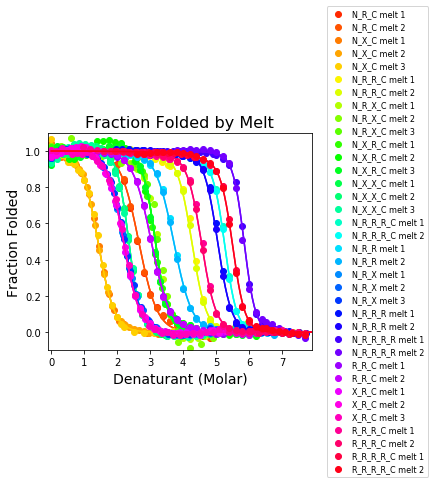

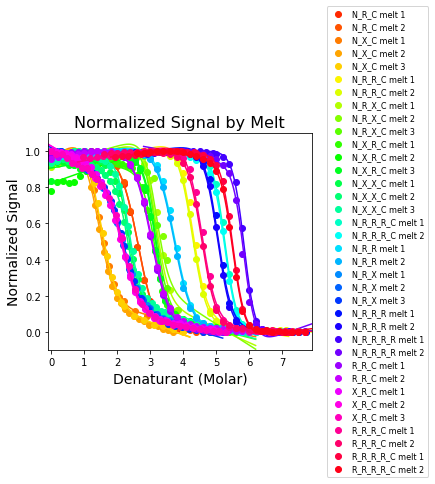

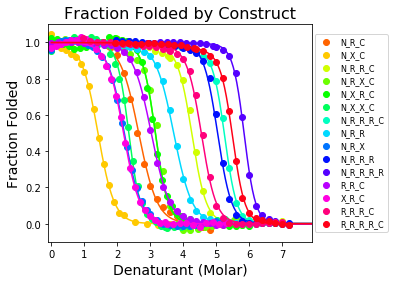

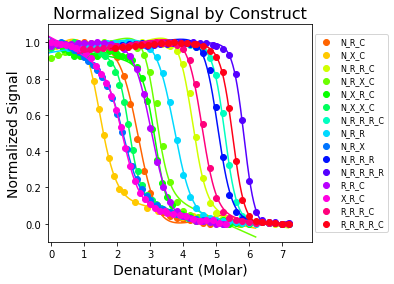

<function matplotlib.pyplot.clf()>

In [5]:
print("\nPlotting results...\n")

# The function "baseline_adj" gives an adjusted y value based on fitted baseline 
# parameters (fraction folded). 
def baseline_adj(y, x, params, construct):
    af = result.params['af_{}'.format(construct)].value
    bf = result.params['bf_{}'.format(construct)].value
    au = result.params['au_{}'.format(construct)].value
    bu = result.params['bu_{}'.format(construct)].value
    return (y-(bu+(au*x)))/((bf+(af*x))-(bu+(au*x)))

# Defining global best-fit parameters
dGN = result.params['dGN'].value
dGR = result.params['dGR'].value
dGX = result.params['dGX'].value
dGC = result.params['dGC'].value
dGRR = result.params['dGRR'].value
dGXX = result.params['dGXX'].value
dGRX = result.params['dGRX'].value
dGXR = result.params['dGXR'].value
mR = result.params['mR'].value
mX = result.params['mX'].value

# The function fit_model used for plotting best-fit lines and for adding  
# residuals to best-fit lines in bootstrapping.  Normalized, not frac folded.
def fit_model(params, x, melt):
    denat = x
    af = result.params['af_{}'.format(melt)].value
    bf = result.params['bf_{}'.format(melt)].value
    au = result.params['au_{}'.format(melt)].value
    bu = result.params['bu_{}'.format(melt)].value
    frac_folded = eval(comp_frac_folded_dict[melt[:-2] + '_comp_ff']) # :-2 leaves off the _1, _2, etc from melt id.    
    return ((af * denat) + bf) * frac_folded + (((au * denat) + bu) * \
            (1 - frac_folded))   

# Finding the maximum denaturant value out of all the melts to
# set x axis bound
denat_maxer = np.zeros(0)
for melt in melts:
    denat_maxer = np.concatenate((denat_maxer, melt_data_dict[melt][:, 0]))
denat_maxer_list = denat_maxer.astype(float)
denat_max = np.max(denat_maxer_list)
denat_bound = np.around(denat_max, 1) + 0.2

# Denaturant values to use when evaluating fits.  Determines how smooth the
# fitted curve will be, based on the third value (300) in the argument below.
# I might keep using this for fraction_foldeed, but for nomralized baseline
# use a local set of points for each melt, so as not to extrapolate the 
# bselines too far.
denat_fit = np.linspace(0, denat_bound, 300)

#defining a dictionary using the first melt of each construct (construct_1)
#Move this to the plotting part, and why not do this for all constructs?
construct1_data_dict = {}
for construct in constructs:
    construct1_data_dict[construct] = np.load('{0}{1}.npy'.format(path, construct + '_1'))

# The four dictionaries below define lower and upper denaturant limnits to be
# used for plotting normalized curves, so crazy-long baseline extrapolations 
# are not shown.  Do both for melts and construct 1.   These are then used
# to create 300-point synthetic baselines in the fifth and sixth dictionaries.
melt_lower_denat_dict = {melt: round(np.min(melt_data_dict[melt][:,0].astype(float))) -0.2 for melt in melts}
melt_upper_denat_dict = {melt: round(np.max(melt_data_dict[melt][:,0].astype(float))) + 0.2 for melt in melts}

construct1_lower_denat_dict = {construct: round(np.min(construct1_data_dict[construct][:,0].astype(float))) - 0.2 for construct in constructs}

construct1_upper_denat_dict = {construct: round(np.max(construct1_data_dict[construct][:,0].astype(float))) + 0.2 for construct in constructs}

melt_denat_synthetic_dict = {
    melt: np.linspace(
        melt_lower_denat_dict[melt],
        melt_upper_denat_dict[melt],
        300
    ) 
    for melt in melts
}

construct1_denat_synthetic_dict = {
    construct: np.linspace(
        construct1_lower_denat_dict[construct],
        construct1_upper_denat_dict[construct], 
        300
    )
    for construct in constructs
}
                        

''' Global Plot Aesthetics'''
# Defining how the plots are colored
num_melt_colors = num_melts
num_construct_colors = num_constructs
coloration = plt.get_cmap('hsv')


# Dictonary defining title font
title_font = {'family': 'arial',
        'color': 'black',
        'weight': 'normal',
        'size': 16}

# Dictionary defining label font
label_font = {'family': 'arial',
        'color': 'black',
        'weight': 'normal',
        'size': 14}

'''First Plot: Fraction Folded by Melt'''
#extracting the melt data and creating plot lines for each melt
colorset = 0 # counter to control color of curves and points
for melt in melts:   
    colorset = colorset + 1
    denat = melt_data_dict[melt][:,0]     # A numpy array of type str
    norm_sig = melt_data_dict[melt][:,1]  # A numpy array of type str
    denat = denat.astype(float) # A numpy array of type float
    norm_sig = norm_sig.astype(float) # A numpy array of type float
    y_adj = baseline_adj(norm_sig, denat, result.params, melt)
    y_fit = fit_model(result.params, denat_fit, melt)
    y_fit_adj = baseline_adj(y_fit, denat_fit, result.params, melt)
    plt.plot(denat, y_adj, 'o', color = coloration(colorset/num_melt_colors),
            label = melt[:-2] + ' melt ' + melt[-1])       
    plt.plot(denat_fit, y_fit_adj, '-', color = coloration(colorset/num_melt_colors))

#set axis limits
axes=plt.gca()
axes.set_xlim([-0.1, denat_bound])
axes.set_ylim([-0.1,1.1])
axes.set_aspect(5.5)

#lot aesthetics and labels
plt.legend(loc = 'center', bbox_to_anchor = (1.25, 0.5), fontsize=8)
plt.title('Fraction Folded by Melt', fontdict = title_font)
plt.xlabel('Denaturant (Molar)', fontdict = label_font)
plt.ylabel('Fraction Folded', fontdict = label_font)

#saving plot in individual doc
plt.savefig('{0}{1}_plot_frac_folded_by_melt'.format(path, proj_name),\
            dpi = 500, bbox_inches='tight')

#show plot in iPython window and then close
plt.show()
plt.close()
plt.clf

'''Second Plot: Normalized Signal by Melt'''
colorset = 0
for melt in melts:   
    colorset = colorset + 1
    denat = melt_data_dict[melt][:,0]     # A numpy array of type str
    norm_sig = melt_data_dict[melt][:,1]  # A numpy array of type str
    denat = denat.astype(float) # A numpy array of type float
    norm_sig = norm_sig.astype(float) # A numpy array of type float
    y_fit = fit_model(result.params, melt_denat_synthetic_dict[melt], melt)
    plt.plot(denat, norm_sig, 'o', color=coloration(colorset/num_melt_colors),
             label = melt[:-2] + ' melt ' + melt[-1]) 
    plt.plot(melt_denat_synthetic_dict[melt], y_fit, '-', \
             color=coloration(colorset/num_melt_colors))

#set axis limits
axes=plt.gca()
axes.set_xlim([-0.1, denat_bound])
axes.set_ylim([-0.1,1.1])
axes.set_aspect(5.5)

#plot aesthetics and labels
plt.legend(loc = 'center', bbox_to_anchor = (1.25, 0.5), fontsize=8)
plt.title('Normalized Signal by Melt', fontdict = title_font)
plt.xlabel('Denaturant (Molar)', fontdict = label_font)
plt.ylabel('Normalized Signal', fontdict = label_font)

#saving plot in individual doc
plt.savefig('{0}{1}_plot_normalized_by_melt'.format(path, proj_name),\
            dpi=500, bbox_inches='tight')

#show plot in iPython window and then close
plt.show()
plt.close()
plt.clf

'''Third Plot: Fraction Folded by Construct'''
colorset = 0
for construct in constructs:   
    colorset = colorset + 1
    denat = construct1_data_dict[construct][:,0]  # A numpy array of type str
    denat_line = construct1_data_dict[construct][:, 0]   # A numpy array of type str
    norm_sig = construct1_data_dict[construct][:, 1]  # A numpy array of type str
    denat = denat.astype(float) # A numpy array of type float
    denat_line = denat_line.astype(float) # A numpy array of type float
    norm_sig = norm_sig.astype(float) # A numpy array of type float
    y_adj = baseline_adj(norm_sig, denat_line, result.params, construct + '_1')
    y_fit = fit_model(result.params, denat_fit, construct + '_1')
    y_fit_adj = baseline_adj(y_fit, denat_fit, result.params, construct + '_1')
    plt.plot(denat, y_adj, 'o', \
             color=coloration(colorset/num_construct_colors), label = construct)       
    plt.plot(denat_fit, y_fit_adj, '-', \
             color=coloration(colorset/num_construct_colors))

#set axis limits
axes=plt.gca()
axes.set_xlim([-0.1, denat_bound])
axes.set_ylim([-0.1,1.1])
axes.set_aspect(5.5)

#plot aesthetics and labels
plt.legend(loc = 'center', bbox_to_anchor = (1.15, 0.5), fontsize=8)
plt.title('Fraction Folded by Construct', fontdict = title_font)
plt.xlabel('Denaturant (Molar)', fontdict = label_font)
plt.ylabel('Fraction Folded', fontdict = label_font)

#saving plot in individual doc
plt.savefig('{0}{1}_plot_frac_folded_by_construct'.format(path, proj_name),\
            dpi=500, bbox_inches='tight')

#show plot in iPython window and then close
plt.show()
plt.close()
plt.clf

'''Fourth Plot: Normalized Signal by Construct'''
colorset = 0
for construct in constructs:   
    colorset = colorset + 1
    denat = construct1_data_dict[construct][:,0]     # A numpy array of type str
    norm_sig = construct1_data_dict[construct][:,1]  # A numpy array of type str
    denat = denat.astype(float) # A numpy array of type float
    norm_sig = norm_sig.astype(float) # A numpy array of type float
    y_fit = fit_model(result.params, construct1_denat_synthetic_dict[construct], \
                      construct + '_1')
    plt.plot(denat, norm_sig, 'o', color = coloration(colorset/num_construct_colors),
             label = construct) 
    plt.plot(construct1_denat_synthetic_dict[construct], y_fit, '-', \
             color = coloration(colorset/num_construct_colors))

#set axis limits
axes=plt.gca()
axes.set_xlim([-0.1, denat_bound])
axes.set_ylim([-0.1,1.1])
axes.set_aspect(5.5)

#plot aesthetics and labels   * ``````
plt.legend(loc = 'center', bbox_to_anchor = (1.15, 0.5), fontsize=8)
plt.title('Normalized Signal by Construct', fontdict = title_font)
plt.xlabel('Denaturant (Molar)', fontdict = label_font)
plt.ylabel('Normalized Signal', fontdict = label_font)

#saving plot in individual doc
plt.savefig('{0}{1}_plot_normalized_by_construct'.format(path, proj_name),\
            dpi=500, bbox_inches='tight')

#show plot in iPython window and then close
plt.show()
plt.close()
plt.clf

## Bootstrap analysis

Asks the user to input the number of bootstrap iterations.  Bootstrap parameters are stored in a list of lists (**bs_param_values**). After performing the specified number of iterations, bootstrapped thermodynamic parameters are written to a csv file.

Again, bootstrapping is meant to be performed after fitting above.  Otherwise, the data and the fit model will have to be re-imported, and the params list and objective function will need to be generated.  Just run the fit again if needed.

In this version, a two minute sleep command is built in every 50 bootstrap iterations to let things cool down.

In [6]:
'''BootStrap analysis'''
# Create list to store bootstrap iterations of values and define column titles
bs_param_values = []  
bs_param_values.append(['Bootstrap Iter', 'dGN', 'dGR', 'dGX', 'dGC', 'dGRR', 
                        'dGXX', 'dGRX', 'dGXR', 'mR', 'mX', 'redchi**2','bestchi**2'])   
#total number of bootstrap iterations 
#bs_iter_tot = input("How many bootstrap iterations? ") 

bs_iter_tot = 10  # You would use this if you did not want user input from screen
bs_iter_count = 0   # Iteration counter
fit_resid_index= len(fit_resid) - 1

y_fitted_dict = {}
# Dictionary of 'true' normalized y values from fit at each denaturant value. 
for melt in melts:
    denat = melt_data_dict[melt][:,0] # A numpy array of type str
    denat = denat.astype(float)       # A numpy array of type float
    y_fitted_dict[melt] = np.array(fit_model(result.params, denat, melt))

# Arrays to store bs fitted param values
dGN_vals = []
dGR_vals = []
dGX_vals = []
dGC_vals = []
dGRR_vals = []
dGXX_vals = []
dGRX_vals = []
dGXR_vals = []
mR_vals = []
mX_vals = []

# Add residuals chosen at random (with replacement) to expected
# y values. Note-residuals are combined ACROSS melts.
for j in range(bs_iter_tot):   
    rand_resid_dict={}  # Clears the random data for each bootsterap iteration
    bs_iter_count = bs_iter_count + 1
    print("Bootstrap iteration {0} out of {1}".format(bs_iter_count, 
                               bs_iter_tot))
    
    for melt in melts:
        rand_resid =[]
        denat = melt_data_dict[melt][:,0] # A numpy array of type str
        denat = denat.astype(float)       # A numpy array of type float
        
        for x in range(len(denat)):  # Creastes a list of random residuals
            rand_int = np.random.randint(0, fit_resid_index)
            rand_resid.append(fit_resid[rand_int])  
 
        rand_resid_dict[melt] = np.array(rand_resid)
        y_bootstrap = y_fitted_dict[melt] + rand_resid_dict[melt]
        z_max,z_min = y_bootstrap.max(), y_bootstrap.min()
        melt_data_dict[melt][:, 1] = (y_bootstrap - z_min)/(z_max - z_min)
    
    bs_result = lmfit.minimize(objective, init_guesses)
    bs_chisqr = bs_result.chisqr
    bs_red_chisqr= bs_result.redchi
    
    dGN = bs_result.params['dGN'].value
    dGR = bs_result.params['dGR'].value
    dGX = bs_result.params['dGX'].value
    dGC = bs_result.params['dGC'].value
    dGRR = bs_result.params['dGRR'].value
    dGXX = bs_result.params['dGXX'].value
    dGRX = bs_result.params['dGRX'].value
    dGXR = bs_result.params['dGXR'].value
    mR = bs_result.params['mR'].value
    mX = bs_result.params['mX'].value
    
    # Store each value in a list for plotting and for downstream statistical analysis
    dGN_vals.append(dGN)
    dGR_vals.append(dGR)
    dGX_vals.append(dGX)
    dGC_vals.append(dGC)
    dGRR_vals.append(dGRR)
    dGXX_vals.append(dGXX)
    dGRX_vals.append(dGRX)
    dGXR_vals.append(dGXR)
    mR_vals.append(mR)
    mX_vals.append(mX)
    
    # Append bootstrapped global parameter values for ouput to a file
    bs_param_values.append([bs_iter_count, dGN, dGR, dGX, dGC, dGRR, dGXX, dGRX, dGXR, mR, mX, 
                            bs_red_chisqr,bs_chisqr])
        
with open('{0}{1}_bootstrap_params.csv'.format(path, proj_name), "w") as n:
    writer = csv.writer(n, delimiter = ',')
    writer.writerows(bs_param_values)
n.close()

Bootstrap iteration 1 out of 10
Bootstrap iteration 2 out of 10
Bootstrap iteration 3 out of 10
Bootstrap iteration 4 out of 10
Bootstrap iteration 5 out of 10
Bootstrap iteration 6 out of 10
Bootstrap iteration 7 out of 10
Bootstrap iteration 8 out of 10
Bootstrap iteration 9 out of 10
Bootstrap iteration 10 out of 10


## The next cell calculates statistical properties of bootstrap parameters and outputs a file

I plan to merge this with the bootstrap cell, but it is much more convenient to code it separately.  

The structure that currently holds the bootstrap parameter values (*bs_param_values*) is a list of lists.  So it needs to be converted to a numpy array, and it needs to have only values, not column heads, in order to do numerical calculations.  Pandas would clearly be the right way to go with this, but not today.

*path* (for writing out the data frame) is taken from the fitting cell above.

In [7]:
bs_param_values_fullarray = np.array(bs_param_values)
bs_param_values_array = bs_param_values_fullarray[1:,1:-2].astype(np.float) # End at -2 since last two columns
                                                                            # are chi square statistics

bs_param_names = bs_param_values_fullarray[0][1:-2]

statistics = ['mean','median','stdev','2.5% CI','16.6% CI','83.7% CI','97.5% CI']

bs_statistics_df = pd.DataFrame(columns = statistics)

i = 0
for param in bs_param_names:
    bs_statistics = []
    bs_statistics.append(np.mean(bs_param_values_array[:,i]))
    bs_statistics.append(np.median(bs_param_values_array[:,i]))
    bs_statistics.append(np.std(bs_param_values_array[:,i]))
    bs_statistics.append(np.percentile(bs_param_values_array[:,i],2.5))
    bs_statistics.append(np.percentile(bs_param_values_array[:,i],16.7))
    bs_statistics.append(np.percentile(bs_param_values_array[:,i],83.3))
    bs_statistics.append(np.percentile(bs_param_values_array[:,i],97.5))
    bs_statistics_df.loc[param] = bs_statistics
    i = i + 1

bs_statistics_df.to_csv('{}{}_bootstrap_stats.csv'.format(path,proj_name))

corr_coef_matrix = np.corrcoef(bs_param_values_array, rowvar = False)
corr_coef_df = pd.DataFrame(corr_coef_matrix, columns = bs_param_names, index = bs_param_names)
corr_coef_df.to_csv('{}{}_bootstrap_corr_coefs.csv'.format(path,proj_name))

In [8]:
bs_statistics_df

,mean,median,stdev,2.5% CI,16.6% CI,83.7% CI,97.5% CI
dGN,4.838058,4.842109,0.049179,4.766315,4.788957,4.878031,4.923331
dGR,4.039844,4.038633,0.036148,3.979546,4.019299,4.055433,4.105345
dGX,5.594242,5.628273,0.113517,5.361961,5.511279,5.680902,5.724224
dGC,6.300722,6.309864,0.053856,6.199074,6.257571,6.343978,6.377473
dGRR,-10.383006,-10.390439,0.082653,-10.505807,-10.438473,-10.326890,-10.225278
dGXX,-10.102701,-10.117087,0.102813,-10.255302,-10.196954,-9.998942,-9.927967
dGRX,-9.356748,-9.363485,0.102315,-9.515155,-9.442038,-9.278536,-9.170732
dGXR,-10.761583,-10.783829,0.099324,-10.892170,-10.854893,-10.678382,-10.581250
mR,0.703325,0.704362,0.005846,0.692721,0.699268,0.708379,0.711526
mX,0.976772,0.982384,0.019758,0.946425,0.949867,0.991990,1.003031


In [9]:
corr_coef_matrix

array([[ 1.        ,  0.9411252 ,  0.67031347,  0.87927555, -0.8958477 ,
        -0.88211099, -0.93274137, -0.70653938,  0.63326143, -0.12781981],
       [ 0.9411252 ,  1.        ,  0.71397517,  0.88855143, -0.91198973,
        -0.85698262, -0.90764487, -0.77759049,  0.62786566, -0.15014979],
       [ 0.67031347,  0.71397517,  1.        ,  0.8384673 , -0.85655883,
        -0.84937993, -0.85548296, -0.75759943,  0.86020389, -0.71557031],
       [ 0.87927555,  0.88855143,  0.8384673 ,  1.        , -0.98767602,
        -0.98109722, -0.90728593, -0.92611203,  0.88440936, -0.26172267],
       [-0.8958477 , -0.91198973, -0.85655883, -0.98767602,  1.        ,
         0.96725538,  0.94575498,  0.87721842, -0.88864885,  0.3226564 ],
       [-0.88211099, -0.85698262, -0.84937993, -0.98109722,  0.96725538,
         1.        ,  0.90973763,  0.89054164, -0.87796811,  0.29001772],
       [-0.93274137, -0.90764487, -0.85548296, -0.90728593,  0.94575498,
         0.90973763,  1.        ,  0.70748165

In [10]:
corr_coef_df

,dGN,dGR,dGX,dGC,dGRR,dGXX,dGRX,dGXR,mR,mX
dGN,1.000000,0.941125,0.670313,0.879276,-0.895848,-0.882111,-0.932741,-0.706539,0.633261,-0.127820
dGR,0.941125,1.000000,0.713975,0.888551,-0.911990,-0.856983,-0.907645,-0.777590,0.627866,-0.150150
dGX,0.670313,0.713975,1.000000,0.838467,-0.856559,-0.849380,-0.855483,-0.757599,0.860204,-0.715570
dGC,0.879276,0.888551,0.838467,1.000000,-0.987676,-0.981097,-0.907286,-0.926112,0.884409,-0.261723
dGRR,-0.895848,-0.911990,-0.856559,-0.987676,1.000000,0.967255,0.945755,0.877218,-0.888649,0.322656
dGXX,-0.882111,-0.856983,-0.849380,-0.981097,0.967255,1.000000,0.909738,0.890542,-0.877968,0.290018
dGRX,-0.932741,-0.907645,-0.855483,-0.907286,0.945755,0.909738,1.000000,0.707482,-0.789464,0.440259
dGXR,-0.706539,-0.777590,-0.757599,-0.926112,0.877218,0.890542,0.707482,1.000000,-0.805017,0.132289
mR,0.633261,0.627866,0.860204,0.884409,-0.888649,-0.877968,-0.789464,-0.805017,1.000000,-0.489777
mX,-0.127820,-0.150150,-0.715570,-0.261723,0.322656,0.290018,0.440259,0.132289,-0.489777,1.000000


## Bootstrap histograms and correlation plots

Plots are generated for the thermodynamic parameters of interest (currently, baseline parameters are not included, thought this would not be hard to generate).  Histograms are generated for each parameter.  Scatter plots are generated for each pair of parameters (not including self-correlation) and arrayed in a grid along with a linear fit.  Shared axes are used in the grid to minimize white-space resulting from labelling each axis.  Thinking about the output as a matrix, the histograms are on the main diagonal, and the correllation plots are off-diagonal elements populating the upper triangle of the matrix.

The plot grid is dumped to the screen below, and is also written as a pdf file.

As with the plotting and bootstrapping scripts above, this is meant to be run after the fitting script (and after the bootstrapping script immediately above).  If you have not done that, re-run fit and bootstrap.

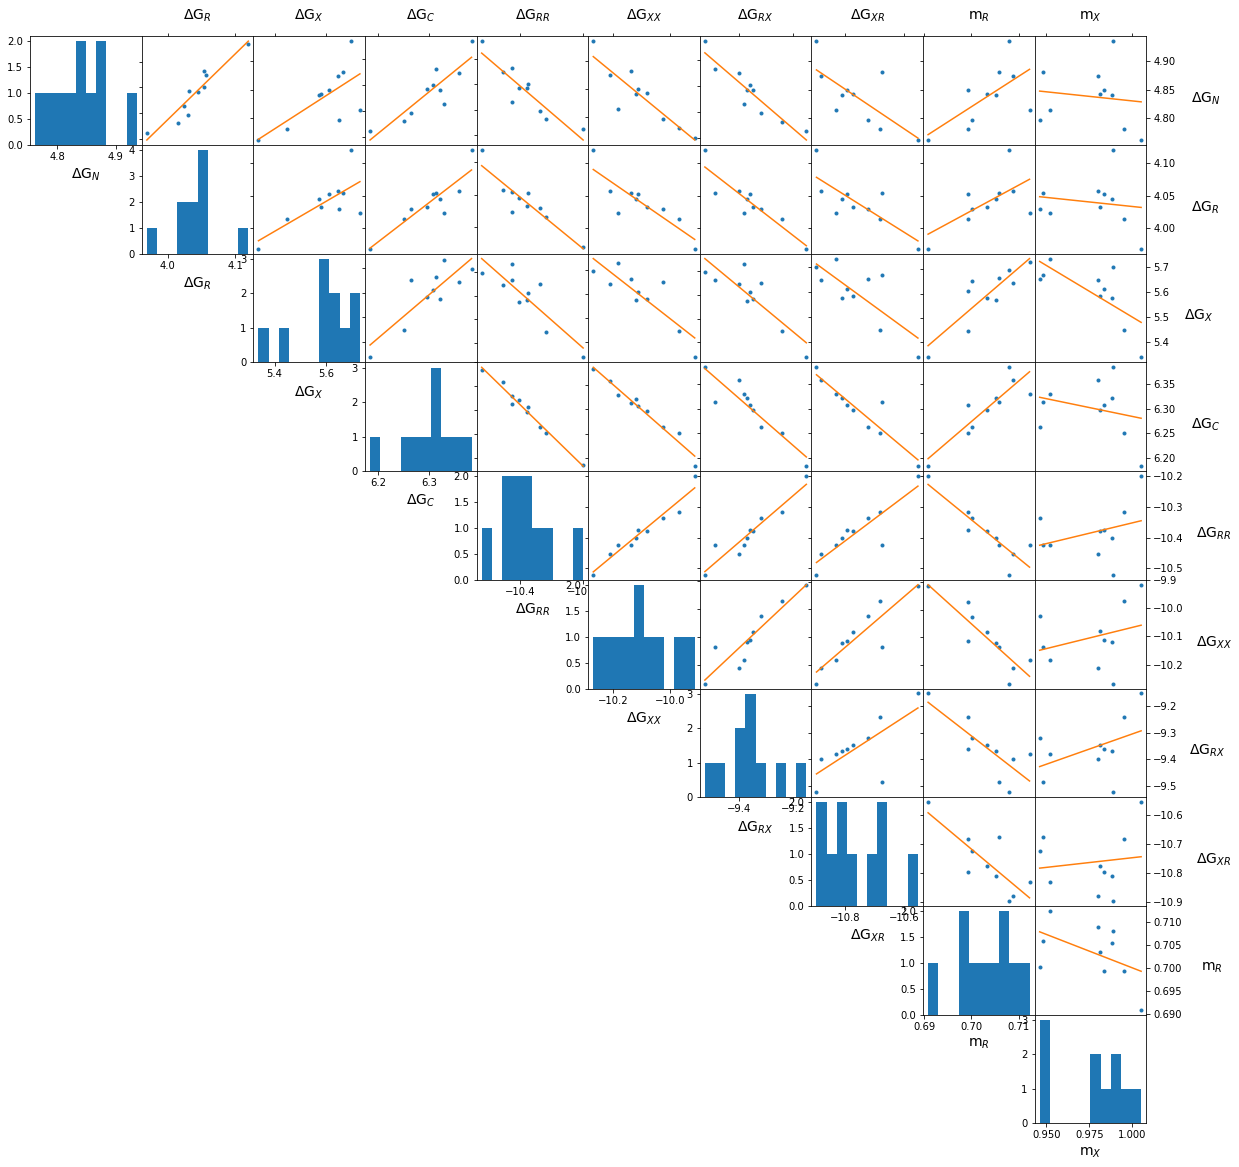

In [11]:
# Specify the names of parameters to be compared to see correlation.
corr_params = ['dGN', 'dGR', 'dGX', 'dGC', 'dGRR', 'dGXX', 'dGRX', 'dGXR', 'mR', 'mX']

# These are a second set of parameter names that follow in the same order
# as in corr_params.  They are formatted using TeX-style names so that Deltas 
# and subscripts will be plotted.  The would not be good key names for dictionaries
corr_param_labels = ['$\Delta$G$_N$', '$\Delta$G$_R$', '$\Delta$G$_X$', '$\Delta$G$_C$', 
               '$\Delta$G$_{RR}$', '$\Delta$G$_{XX}$', '$\Delta$G$_{RX}$', '$\Delta$G$_{XR}$', 'm$_R$', 'm$_X$']

num_corr_params = len(corr_params)
gridsize = num_corr_params  # Determines the size of the plot grid.

# Dictionary of fitted parameter values.
corr_params_dict = {'dGN': dGN_vals, 'dGR': dGR_vals, 'dGX': dGX_vals, 'dGC': dGC_vals,\
                    'dGRR': dGRR_vals, 'dGXX': dGXX_vals, 'dGRX': dGRX_vals, 'dGXR': dGXR_vals, 
                    'mR': mR_vals, 'mX': mX_vals}

# PDF that stores a grid of the correlation plots
with PdfPages('{0}{1}_Corr_Plots.pdf'.format(path, proj_name)) as pdf:
    fig, axs = plt.subplots(ncols=gridsize, nrows=gridsize, figsize=(20, 20))
    
    # Turns off axes on lower triangle
    axs[1, 0].axis('off')
    axs[2, 0].axis('off')
    axs[2, 1].axis('off')
    axs[3, 0].axis('off')
    axs[3, 1].axis('off')
    axs[3, 2].axis('off')
    axs[4, 0].axis('off')
    axs[4, 1].axis('off')
    axs[4, 2].axis('off')
    axs[4, 3].axis('off')
    axs[5, 0].axis('off')
    axs[5, 1].axis('off')
    axs[5, 2].axis('off')
    axs[5, 3].axis('off')
    axs[5, 4].axis('off')
    axs[6, 0].axis('off')
    axs[6, 1].axis('off')
    axs[6, 2].axis('off')
    axs[6, 3].axis('off')
    axs[6, 4].axis('off')
    axs[6, 5].axis('off')
    axs[7, 0].axis('off')
    axs[7, 1].axis('off')
    axs[7, 2].axis('off')
    axs[7, 3].axis('off')
    axs[7, 4].axis('off')
    axs[7, 5].axis('off')
    axs[7, 6].axis('off')
    axs[8, 0].axis('off')
    axs[8, 1].axis('off')
    axs[8, 2].axis('off')
    axs[8, 3].axis('off')
    axs[8, 4].axis('off')
    axs[8, 5].axis('off')
    axs[8, 6].axis('off')
    axs[8, 7].axis('off')
    axs[9, 0].axis('off')
    axs[9, 1].axis('off')
    axs[9, 2].axis('off')
    axs[9, 3].axis('off')
    axs[9, 4].axis('off')
    axs[9, 5].axis('off')
    axs[9, 6].axis('off')
    axs[9, 7].axis('off')
    axs[9, 8].axis('off')

    # Defines the position of the y paramater from the array of params
    hist_param_counter = 0
    while hist_param_counter < num_corr_params:
        hist_param_label = corr_param_labels[hist_param_counter]
        hist_param = corr_params[hist_param_counter]
        # Start fixing labels here
        #plt.xticks(fontsize=8)
        #axs[hist_param_counter, hist_param_counter].tick_params(fontsize=8)
        #axs[hist_param_counter, hist_param_counter].yticks(fontsize=8)
        axs[hist_param_counter, hist_param_counter].hist(corr_params_dict[hist_param])
        axs[hist_param_counter, hist_param_counter].set_xlabel(hist_param_label,
                   fontsize=14, labelpad = 5)
        hist_param_counter = hist_param_counter + 1  
    
    # This part generates the correlation plots
    y_param_counter = 0
    while y_param_counter < num_corr_params - 1:
        # Pulls the parameter name for the y-axis label (with TeX formatting)
        yparam_label = corr_param_labels[y_param_counter]
        # Pulls the parameter name to be plotted on the y-axis
        yparam = corr_params[y_param_counter]
        
        # Defines the position of the x paramater from the array of params.
        # The + 1 offest avoids correlating a parameter with itself.
        x_param_counter = y_param_counter + 1
        
        while (x_param_counter < num_corr_params):
            #pulls the parameter name for the x-axis label (with TeX formatting)
            xparam_label = corr_param_labels[x_param_counter]
            # Pulls the parameter name to be plotted on the x-axis
            xparam = corr_params[x_param_counter]
            
            x_vals= corr_params_dict[xparam]
            y_vals = corr_params_dict[yparam]
            
            #plt.xticks(fontsize=8)
            #plt.yticks(fontsize=8)
            #plotting scatters with axes.  +1 shifts a plot to the right from main diagonal
            axs[y_param_counter, x_param_counter].plot(x_vals, y_vals, '.')
            
            # The if statement below turns off numbers on axes if not the right column and
            # not the main diagonal.
            if x_param_counter < num_corr_params - 1:
                axs[y_param_counter, x_param_counter].set_xticklabels([])
                axs[y_param_counter, x_param_counter].set_yticklabels([])
                           
            if y_param_counter == 0:  # Puts labels above axes on top row
                axs[y_param_counter, x_param_counter].xaxis.set_label_position('top')
                axs[y_param_counter, x_param_counter].set_xlabel(xparam_label,
                   labelpad = 10, fontsize=14)
                axs[y_param_counter, x_param_counter].xaxis.tick_top()
                if x_param_counter < num_corr_params - 1:  # Avoids eliminating y-scale from upper right corner
                    axs[y_param_counter, x_param_counter].set_yticklabels([])
           
            if x_param_counter == num_corr_params - 1:  #  Puts labels right of right column
                axs[y_param_counter, x_param_counter].yaxis.set_label_position('right')
                axs[y_param_counter, x_param_counter].set_ylabel(yparam_label, 
                   rotation = 0, labelpad = 30, fontsize=14)
                axs[y_param_counter, x_param_counter].set_xticklabels([])
                axs[y_param_counter, x_param_counter].yaxis.tick_right()
               
            # Determin correlation coefficient and display under subplot title
            # Note, there is no code that displays this value at the moment.
            #corr_coef = np.around(np.corrcoef(x_vals, y_vals), 3)
            
            #min and max values of the x param
            x_min = np.min(x_vals)
            x_max = np.max(x_vals)
            
            #fitting a straight line to the correlation scatterplot
            fit_array = np.polyfit(x_vals, y_vals, 1)
            fit_deg1_coef = fit_array[0]
            fit_deg0_coef = fit_array[1]      
            fit_x_vals = np.linspace(x_min, x_max, 10)
            fit_y_vals = fit_deg1_coef*fit_x_vals + fit_deg0_coef
            
            #plotting correlation line fits
            axs[y_param_counter, x_param_counter].plot(fit_x_vals, 
               fit_y_vals)
            plt.subplots_adjust(wspace=0, hspace=0)
            
            x_param_counter = x_param_counter + 1            
        y_param_counter = y_param_counter + 1
    
    pdf.savefig(bbox_inches='tight')